In [1]:
%matplotlib inline

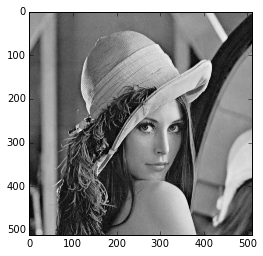

In [7]:
from scipy import misc
l = misc.lena()
misc.imsave('lena.jpg', l) # uses the Image module (PIL)

import matplotlib.pyplot as plt
plt.imshow(l,cmap=plt.cm.gray)
plt.show()

In [6]:
print l
l.shape

[[162 162 162 ..., 170 155 128]
 [162 162 162 ..., 170 155 128]
 [162 162 162 ..., 170 155 128]
 ..., 
 [ 43  43  50 ..., 104 100  98]
 [ 44  44  55 ..., 104 105 108]
 [ 44  44  55 ..., 104 105 108]]


(512, 512)

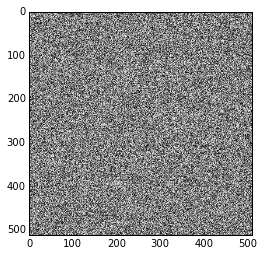

In [16]:
import random
image = []
for i in range(0, 512):
    x = [random.randint(0, 255) for p in range(0, 512)]
    image.append(x)
#print image
plt.imshow(image,cmap=plt.cm.gray)
misc.imsave('random.jpg', image)
plt.show()   

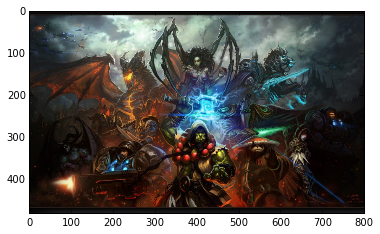

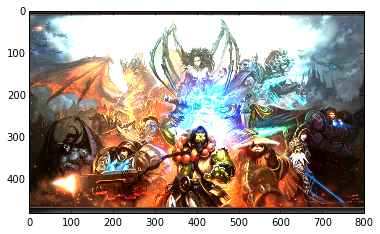

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def clamp(num):
    if num < 0:
        return 0
    elif num > 255:
        return 255
    else:
        return num

image = mpimg.imread("heroes.jpg")
plt.imshow(image)
plt.show()
height = image.shape[0]
width = image.shape[1]
for j in range(0, height):
    for i in range(0, width):
        image[j][i] = [clamp(k * 3) for k in image[j][i]]
plt.imshow(image)
misc.imsave('changed.jpg', image)
plt.show()